# Integrating Unsupervised Clustering with NLP for Online Job Fraud Detection 

# Packages

In [1]:
# Load the Drive helper
from google.colab import drive

# Mount google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import spacy.cli #spacy command line interface

spacy.cli.download('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:626: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 159.7 MB/s eta 0:00:0000:0100:01


DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [29]:
# df = pd.read_csv('./drive/My Drive/nlp/data/fake_job_postings.csv', encoding = "ISO-8859-1")
df = pd.read_csv('./fake_job_postings.csv', encoding = "ISO-8859-1")

# Convert features - Flip
df['has_no_company_logo'] = (df['has_company_logo'] * (-1)) + 1
df['has_no_questions'] = (df['has_questions'] * (-1)) + 1
df.drop(['has_company_logo', 'has_questions'], axis=1, inplace=True)

print("Data Shape:", df.shape)
print("#####################################################")
print(df.info())
print("#####################################################")
print(df.describe())
print("#####################################################")

# Sample data - Fake and Real job posts
# display(df[df['fraudulent'] == 1].rename_axis('Fraudulent').sample(3, random_state=99))
# print("#####################################################")
# display(df[df['fraudulent'] == 0].rename_axis('Real').sample(3, random_state=99))
# print("#####################################################")

# Print sample job title and description
print("Fake Job Post")
print("Sample title:", df.loc[df['fraudulent'] == 1, 'title'].sample(1, random_state=1).values)
print("Description :", df.loc[df['fraudulent'] == 1,'description'].sample(1, random_state=1).values)
print("#####################################################")
print("Real Job Post")
print("Sample title:", df.loc[df['fraudulent'] == 0, 'title'].sample(1, random_state=1).values)
print("Description :", df.loc[df['fraudulent'] == 0,'description'].sample(1, random_state=1).values)

Data Shape: (17880, 18)
#####################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  employment_type      14409 non-null  object
 11  required_experience  10830 non-null  object
 12  required_education   9775 non-null   object
 13  industry             12977 non-null  object
 14  function             114

> Upon examining the sampled dataset, I noticed that the texts contain non-alphabetic characters, such as (Â Â), and URL strings. I plan to clean these texts by retaining only the content words that capture the essence of the job posts for semantic analysis.

## Downsample

The distribution between fraudulent and non-fraudulent labels is imbalanced. To address this, I will downsample the dataset to achieve an equal representation.

In [30]:
print("#####################################################")
print(df['fraudulent'].value_counts())
print("#####################################################")

# Separate the dataset into two DataFrames based on the label
df_real = df[df['fraudulent'] == 0]
df_fake = df[df['fraudulent'] == 1]

# Downsample the 'Real' class
df_nlp = pd.concat([df_real.sample(n=len(df_fake), random_state=99), df_fake])

# Shuffle the dataset to mix 'Fake' and 'Real' rows
df_nlp = df_nlp.sample(frac=1, random_state=99).reset_index(drop=True)

df_nlp['fraudulent'].value_counts()

#####################################################
0    17014
1      866
Name: fraudulent, dtype: int64
#####################################################


0    866
1    866
Name: fraudulent, dtype: int64

## Cleaning and Combining Texts
- There are numerous NaN values. Instead of removing these, considering other columns might contain useful information in the same row, I substituted these fields with a blank space (" ") and combine all fields into a single text column.
- I removed non-alphabetical characters (such as Â, â¢Â, Â, Â), and URLs.
- I avoided eliminating punctuation prior to tokenization, acknowledging that the tokenizer leverages punctuation marks to accurately segment text. Consequently, I selectively removed non-alphabetic characters with ASCII codes above 127 to preserve punctuation, thereby optimizing the text for tokenization.

In [31]:
import re
from spacy.lang.en.stop_words import STOP_WORDS

# Print text columns
text_columns = df_nlp.select_dtypes(include=['object']).columns
print("Length:", len(text_columns))
print("Column:", text_columns)

# Fill Nan with empty string and combine all text columns
df_nlp[text_columns] = df_nlp[text_columns].fillna('')
df_nlp['all_texts'] = df_nlp[text_columns].apply(lambda x: ' '.join(x), axis=1)

# Tokenize, lemmatize, and remove stop words
def tokenize_text(text, remove_stop_words=True):
    text = re.sub(r'#URL\S+', '', text)        # Remove URLs
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove ASCII greater than 127 - tokenizer uses punctuation information to accurately tokenize a text.
    tokens = [tok.lemma_.lower() for tok in nlp(text) if not tok.is_punct and not tok.is_space]
    tokens = [word for word in tokens if word not in STOP_WORDS] # Remove stop words
    cleaned_text = ' '.join(tokens)
    return cleaned_text

df_nlp['all_texts']=df_nlp['all_texts'].apply(tokenize_text)
df_nlp['all_texts'].sample(3)

Length: 13
Column: Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],
      dtype='object')


800     english teacher abroad wa tacoma help teacher ...
1308    customer service reps customer service seek cu...
634     sale professional- mid market md baltimore sal...
Name: all_texts, dtype: object

# Clustering

In the clustering analysis, I used Principal Component Analysis (PCA) and K-means Clustering techniques. PCA served as a method for reducing dimensionality, and visualization. Subsequently, K-means Clustering was utilized to group observations within the dataset into clusters. I adopted this approach to gain insights into the data and identify patterns.


In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

doc_vectors = np.array([nlp(doc).vector for doc in df_nlp['all_texts']])
print("Shape:", doc_vectors.shape)

Shape: (1732, 300)


## PCA & K-means Clustering

- The dimensionality was reduced from 300 to 2.
- PCA transforms the original variables into a new set of dimensions so that the first few retain most of the variation found across all original variables.
- The goal of K-means is to classify data points into clusters such that the points in the same cluster are more similar to each other than to those in other clusters. This similarity is measured based on the Euclidean distance of text vectors.

Shape: (1732, 3)


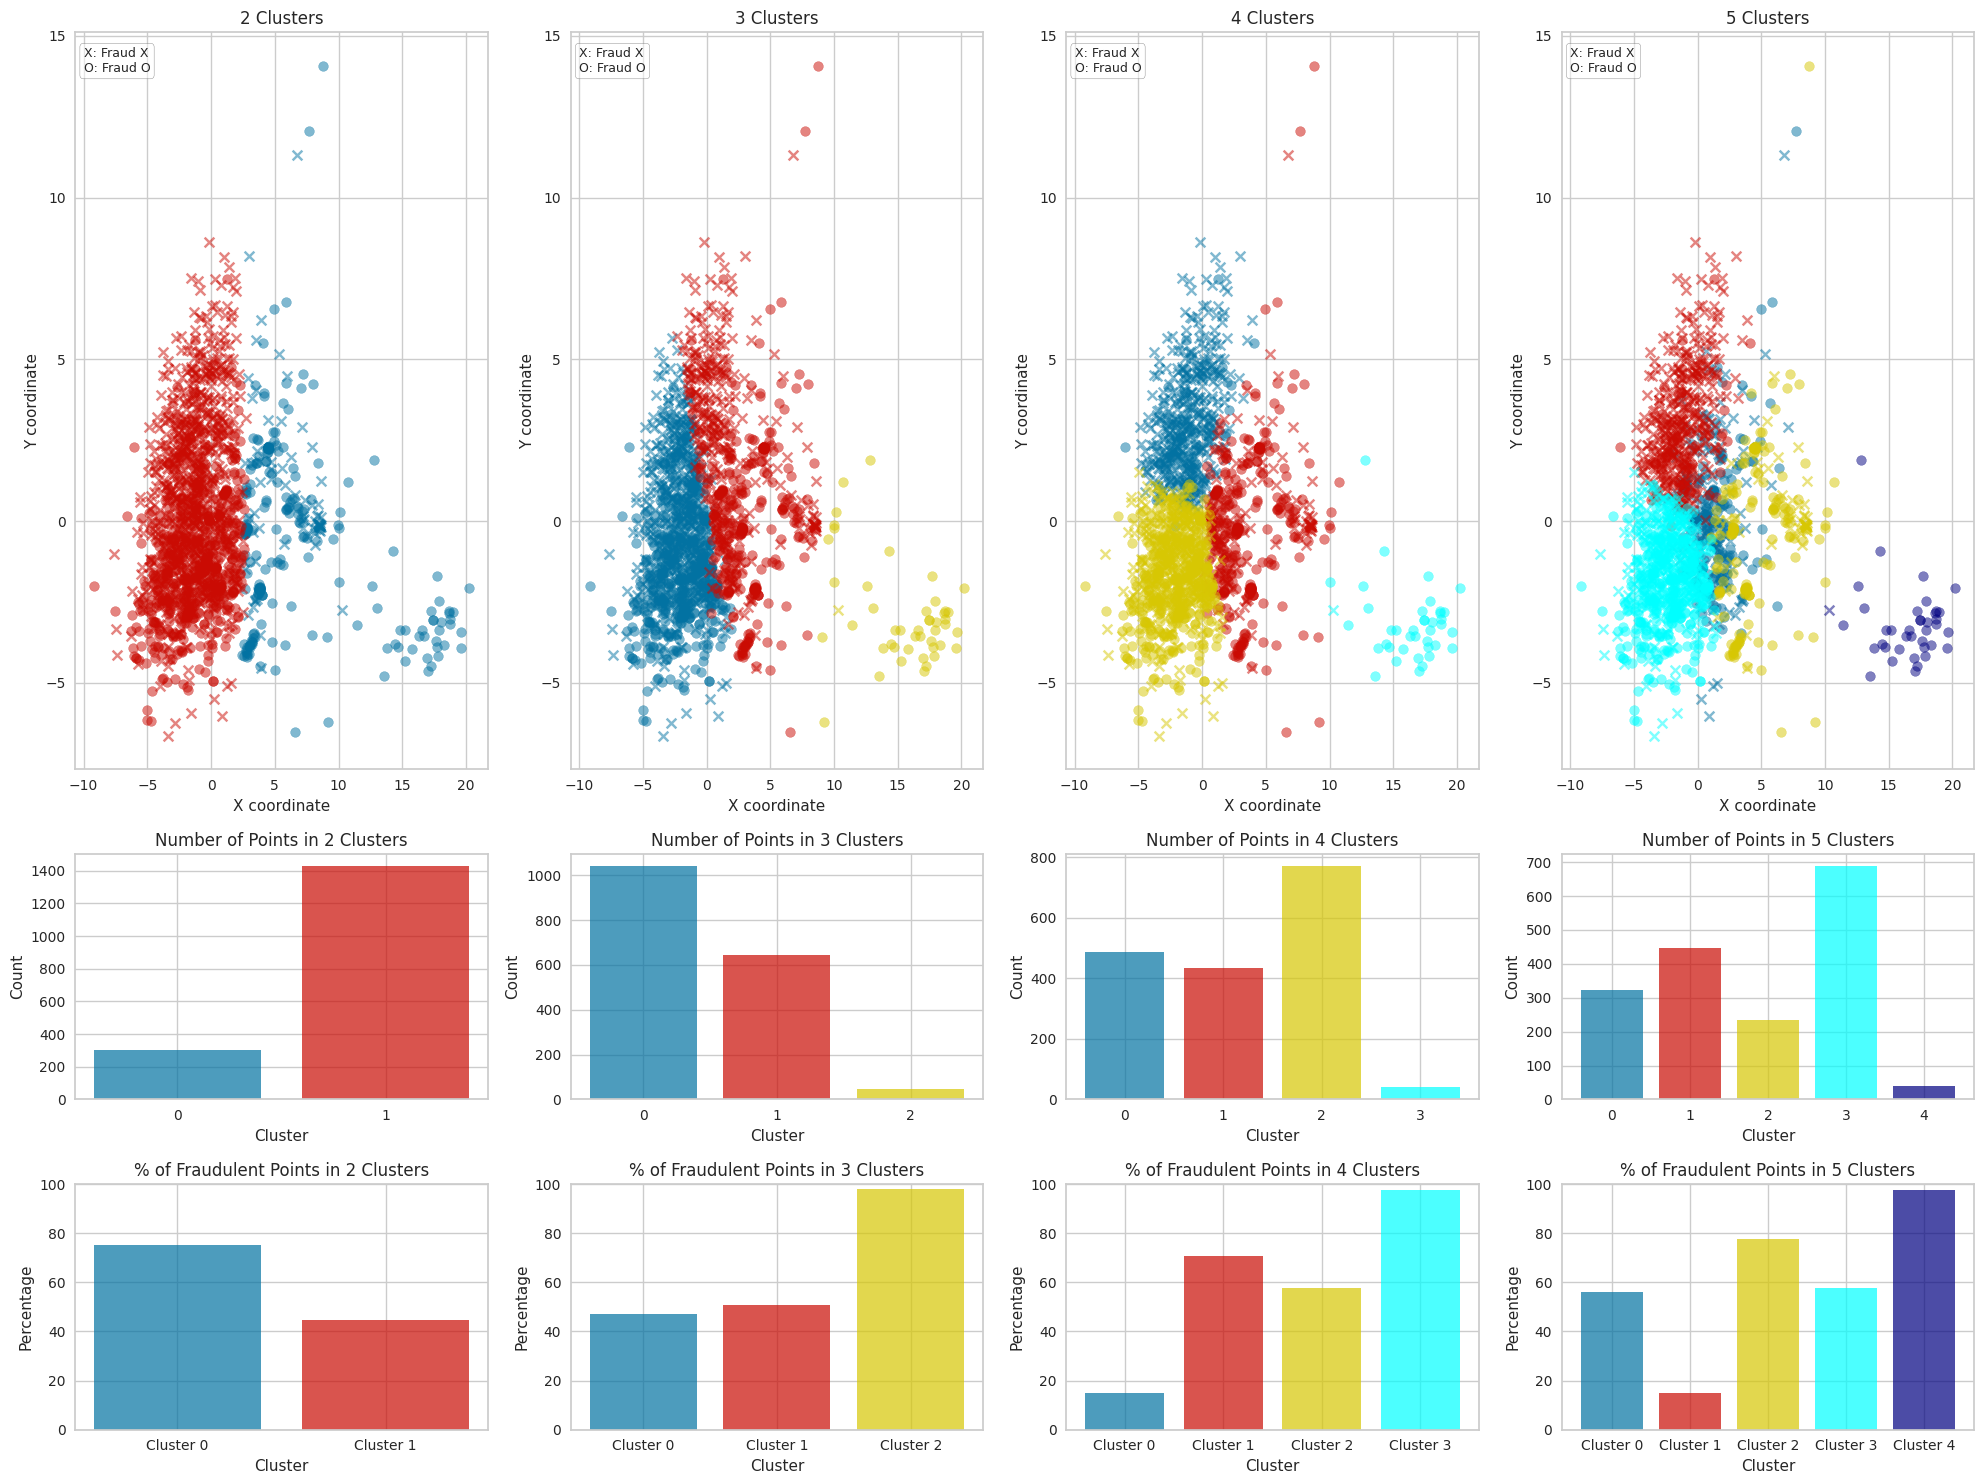

In [33]:
df_plot = pd.DataFrame()
df_plot['fraudulent'] = df_nlp['fraudulent'].values

# Function to add cluster labels to the dataframe
def kmeans_cluster_labels(df, vectors, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, n_init=10, random_state=99)
    kmeans.fit(X=vectors)
    df[f'cluster_{n_clusters}'] = kmeans.labels_

# Define markers for non-fraudulent and fraudulent
markers = {0: 'x', 1: 'o'}  # 0: non-fraudulent, 1: fraudulent

# Colors for different clusters
colors = ['b', 'r', 'y', 'cyan', 'navy']
# colors = ['#000000', '#404040', '#808080', '#BFBFBF', '#F0F0F0']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
pca_result = pca.fit_transform(doc_vectors)
df_plot[['x', 'y']] = pca_result[:, [0, 1]]
print("Shape:", df_plot.shape)

# Define the range of clusters to analyze
cluster_range = [2, 3, 4, 5]

# Create a larger subplot grid
# fig, axes = plt.subplots(2, len(cluster_range), figsize=(5 * len(cluster_range), 10), gridspec_kw={'height_ratios': [3, 1]})
fig, axes = plt.subplots(3, len(cluster_range), figsize=(5 * len(cluster_range), 15), gridspec_kw={'height_ratios': [3, 1, 1]})

# The first row of subplots with scatter plots
for ax, n_clusters in zip(axes[0], cluster_range):
    # K means cluster
    kmeans_cluster_labels(df_plot, doc_vectors, n_clusters)

    # Plot each cluster with a different color
    for i in range(n_clusters):
        cluster_data = df_plot[df_plot[f'cluster_{n_clusters}'] == i]
        # Plot non-fraudulent points
        for fraud_status, marker in markers.items():
            data_to_plot = cluster_data[cluster_data['fraudulent'] == fraud_status]
            ax.scatter(data_to_plot['x'], data_to_plot['y'], marker=marker, color=colors[i % len(colors)], alpha=0.5, label=f'Cluster {i}, Fraud: {"O" if fraud_status else "X"}')

    # Set subplot title and labels
    ax.set_title(f'{n_clusters} Clusters')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    # ax.legend(title="Clusters")
    ax.text(0.02, 0.98, 'X: Fraud X\nO: Fraud O', transform=ax.transAxes,
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.5))


# The second row of subplots with bar plots
for ax, n_clusters in zip(axes[1], cluster_range):
    # Count the number of elements in each cluster
    cluster_counts = df_plot[f'cluster_{n_clusters}'].value_counts().sort_index()

    # Bar plot for each cluster count
    ax.bar(cluster_counts.index, cluster_counts.values, color=colors[:n_clusters], alpha=0.7)

    # Set subplot title and labels
    ax.set_title(f'Number of Points in {n_clusters} Clusters')
    ax.set_xlabel('Cluster')
    ax.set_xticks(cluster_counts.index)
    ax.set_ylabel('Count')

# Adding a new row for the percentage of fraudulent nodes
for ax, n_clusters in zip(axes[2], cluster_range):
    # Calculate the percentage of fraudulent nodes per cluster
    for i in range(n_clusters):
        cluster_data = df_plot[df_plot[f'cluster_{n_clusters}'] == i]
        num_fraudulent = cluster_data['fraudulent'].sum()
        percentage = (num_fraudulent / len(cluster_data)) * 100
        ax.bar(i, percentage, color=colors[i % len(colors)], alpha=0.7)

    ax.set_title(f'% of Fraudulent Points in {n_clusters} Clusters')
    ax.set_xlabel('Cluster')
    ax.set_xticks(range(n_clusters))
    ax.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 100)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The plots show that a small portion of fraudulent job posts is located on the upper left side, while a larger portion is found on the lower right side.

## Silhouette Analysis (Number of Clusters)

The Silhouette analysis is a technique used to determine the optimal number of clusters for a dataset in cluster analysis. It evaluates the quality of clustering by measuring how similar a point is to its own cluster compared to other clusters.
   
   $$s = \frac{(b - a)}{\max(a, b)}$$

- s: The silhouette score for a single data point.
- a: The average distance between that point and the rest of the points in the cluster.
- b: The average distance between that point and all of the points in the cluster nearest to it.

A high value indicates that a point is well matched to its own cluster and poorly matched to neighboring clusters.

For n_clusters = 2, the average silhouette_score is : 0.27
For n_clusters = 3, the average silhouette_score is : 0.14
For n_clusters = 4, the average silhouette_score is : 0.1
For n_clusters = 5, the average silhouette_score is : 0.11
##################################################


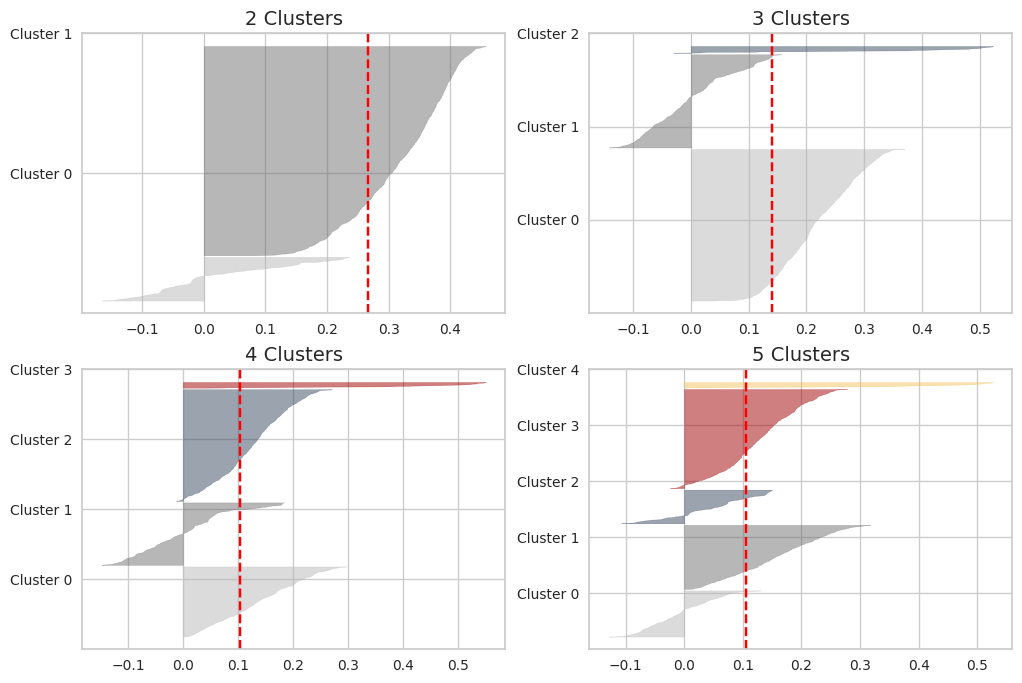

In [104]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# colors = ['b', 'r', 'y', 'navy', 'cyan']
colors = ['#b8b8b8', '#707070', '#384860', '#a00000', '#f2c45f']
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i in [2, 3, 4, 5]:
    # Create KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=99)
    labels = kmeans.fit_predict(doc_vectors)
    s_coef = silhouette_score(doc_vectors, labels)
    print(f"For n_clusters = {i}, the average silhouette_score is :", round(s_coef, 2))

    # Fit the visualizer
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(kmeans, colors=colors[:i], ax=ax[q-1][mod])
    visualizer.fit(doc_vectors)

    # Place y-ticks
    y_lower, y_upper = ax[q-1][mod].get_ylim()
    y_ticks = [y_lower + (y_upper - y_lower) * (j + 1) / i for j in range(i)]
    ax[q-1][mod].set_yticks(y_ticks)
    ax[q-1][mod].set_yticklabels([f'Cluster {j}' for j in range(i)], fontsize=10)

    # Set the subplot title
    ax[q-1][mod].set_title(f'{i} Clusters', fontsize=14)

print("#"*50)
# fig.suptitle("Silhouette plot for clusters 2 to 5")
plt.show()

> Based on the plots, **I have decided on the number of clusters as 4**. Although clustering into two groups yields the highest average silhouette score of 0.27, this structure is not optimal because it results in an uneven distribution of data points across the groups. Furthermore, all data points in cluster 0 (represented in blue) fall below the average silhouette coefficient, which indicates suboptimal cohesion and separation. Similar issues are observed with the configuration of three clusters. Moreover, clustering into five groups leads to negative values in cluster 3 (represented in navy), further indicating poor cluster formation. Therefore, while not ideal, clustering into four groups appears to be the most balanced solution among the arrangements examined.

## Frequent Words for Clusters

Based on the four clusters I have determined, I examined the most frequent words within each cluster.

### Identified Pattern for Fraudulent Job Posts

Initially, I will focus on the cluster located in the bottom-right area, which contains a large number of fake job postings.

In [35]:
# Sample documents in cluster 2, well identified as fraudulent
kmeans_cluster_labels(df_nlp, doc_vectors, n_clusters=4)
df_nlp[df_nlp['cluster_4']==2].sample(3, random_state=99)['all_texts'].values

array(['senior project manager ga atlanta expert services create world lead lean customer experience platform think gartner backbase consistently place visionary quadrant gartners magic quadrant horizontal portal software 2014 recognize visionary portal vendor backbase customer experience platform cxp design help organize create manage deeply relevant customer experience channel device combine late innovation customer experience design ux generation technology deliver unbeatable digital experience backbase team 200 consultant technology usability professional office london amsterdam new york atlanta moscow s plenty information company product website view working backbase video publish youtube check video hereif d like join d love hear teamthe senior project consultantis expert services es team base atlanta es team specialist right level skill experience sure product implement successfully customer additionally es provide training implementation support service customer partner consult

Shape: (1732, 4)


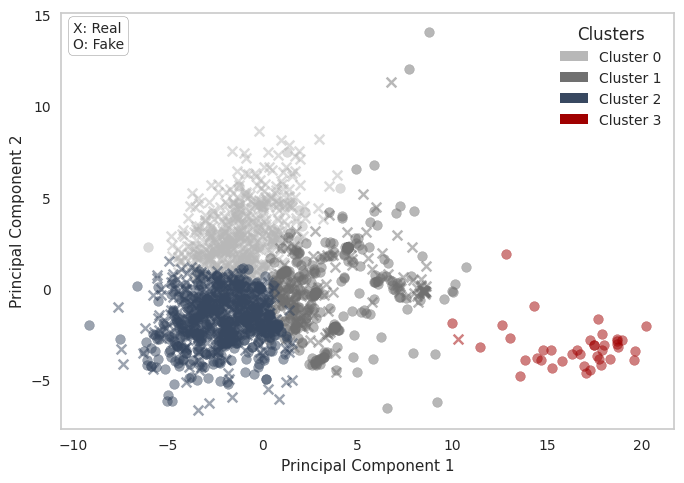

In [133]:
from matplotlib.patches import Patch

df_plot = pd.DataFrame()
df_plot['fraudulent'] = df_nlp['fraudulent'].values
df_plot['cluster_4'] = df_nlp['cluster_4'].values

# Define the range of clusters to analyze
n_clusters = 4

# Define markers for non-fraudulent and fraudulent
markers = {0: 'x', 1: 'o'}  # 0: non-fraudulent, 1: fraudulent

# Colors for different clusters
# colors = ['b', 'r', 'y', 'cyan', 'navy']
colors = ['#b8b8b8', '#707070', '#384860', '#a00000', '#f2c45f']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
pca_result = pca.fit_transform(doc_vectors)
df_plot[['x', 'y']] = pca_result[:, [0, 1]]
print("Shape:", df_plot.shape)

# Create a figure
fig, ax = plt.subplots(figsize=(7, 5))

# Scatter plot
for i in range(n_clusters):
    for fraud_status, marker in markers.items():
        cluster_data = df_plot[(df_plot['cluster_4'] == i) & (df_plot['fraudulent'] == fraud_status)]
        ax.scatter(cluster_data['x'], cluster_data['y'], 
                   marker=marker, color=colors[i], alpha=0.5)

# Create a custom legend with color patches
legend_patches = [Patch(facecolor=colors[i], label=f'Cluster {i}') for i in range(n_clusters)]

# Create the legend with only the cluster color information
ax.legend(handles=legend_patches, loc='upper right', title="Clusters")

# Formatting the plot
ax.grid(False)  # Remove grid
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.text(0.02, 0.98, 'X: Real\nO: Fake', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.5))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [36]:
from collections import Counter

# Function to find the 10 most frequent words for a given cluster
def top_words_cluster(df, cluster_id, n_top=10):
    # Filter the DataFrame for the given cluster
    cluster_df = df[df['cluster_4'] == cluster_id]

    # Combine all texts into a single string and split it into words
    texts_combined = ' '.join(cluster_df['all_texts'].tolist())
    words = texts_combined.split()

    # Count the frequencies of each word
    word_counts = Counter(words)

    # Find the n_top most common words and their counts
    most_common_words = word_counts.most_common(n_top)

    return most_common_words

# Analyze for each cluster
data_top_words = {}
for cluster_id in range(4):
    top_words = top_words_cluster(df_nlp, cluster_id)
    data_top_words[f'Cluster_{cluster_id}'] = [w for w, freq in top_words]

# Create DataFrame
df_top_words = pd.DataFrame(data_top_words)

# Display the DataFrame
print("Top 10 words for each cluster:")
display(df_top_words)

Top 10 words for each cluster:


,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,work,work,work,time
1,team,time,experience,$
2,experience,experience,service,cash
3,product,amp,customer,start
4,company,service,business,require
5,time,job,team,day
6,design,position,time,experience
7,new,company,product,amp
8,technology,customer,project,free
9,business,entry,skill,work


> The analysis reveals the top ten most frequent words for each cluster. We need to particularly focus on cluster 2, which exhibit a significant difference in the proportion of fraudulent job posts. Words like 'work', 'experience', 'customer', and 'service' are more prevalent in cluster 1. This suggests real job posts focus on conveying clear expectations and requirements related to customer service, business development, or product management. Conversely, words such as 'time', '$' (dollar sign), 'cash', and 'start' are common in cluster 2. It implies that fake jobs frequently use enticing language to quickly capture attention for immediate financial gain, urgency, or work flexibility.

## Statistical Analysis

### Chi-Square Test

#### Hypothesis
- **Null Hypothesis**: The cluster assignment is independent of the 'fraudulent' status.

- **Alternative Hypothesis**: The cluster assignment depends on the 'fraudulent' status.

### Table:


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
fraudulent,,,,
0,413,126,326,1
1,73,307,447,39


### Table (Percentage):


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
fraudulent,,,,
0,85.0 %,29.1 %,42.2 %,2.5 %
1,15.0 %,70.9 %,57.8 %,97.5 %


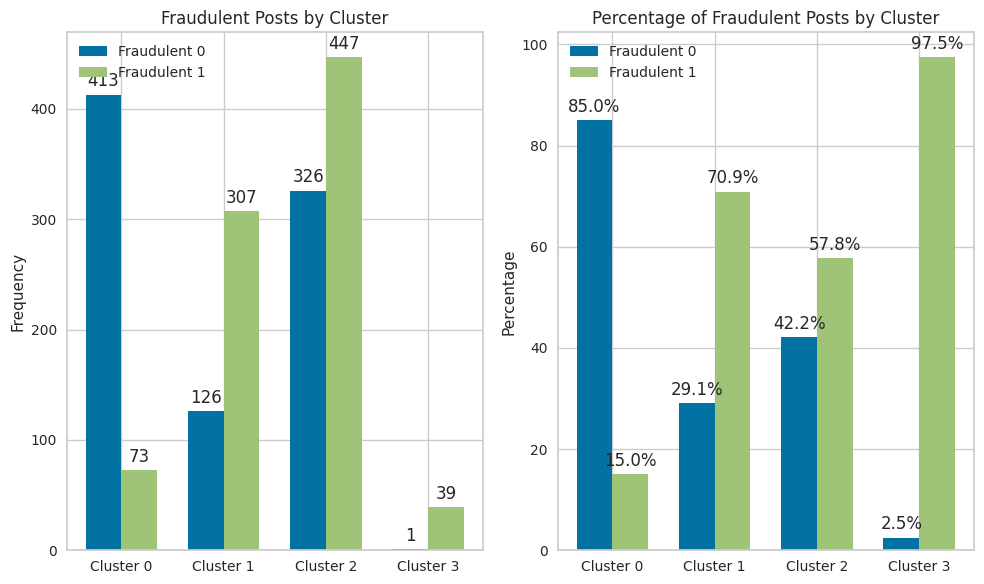

Degrees of Freedom = 3
Chi-Square Value   = 368.5611
P-Value            = 0.000000000000000

Is there a significant difference between the clusters? 
Yes


In [69]:
from scipy.stats import chi2_contingency

# Get the frequency counts of 'fraudulent' for each cluster
tbl = pd.crosstab(df_nlp['fraudulent'], df_nlp['cluster_4'])
tbl_pct = tbl.div(tbl.sum(axis=0), axis=1) * 100
tbl.columns = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3" ]
tbl_pct.columns = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3" ]

print("### Table:")
display(tbl)

print("### Table (Percentage):")
display(tbl_pct.round(1).applymap(lambda x: str(x)+" %"))

### Visualization
labels = list(tbl.keys())
cluster_0_counts = [tbl[label][0] for label in labels]
cluster_1_counts = [tbl[label][1] for label in labels]

cluster_0_pct = tbl_pct.iloc[0, :].values
cluster_1_pct = tbl_pct.iloc[1, :].values

# Function to add labels on the bars
def autolabel(rects, ax, is_pct=False):
    """Attach a text label above each bar in *rects*, displaying its height as an integer or a percentage."""
    for rect in rects:
        height = rect.get_height()
        label_format = f'{height:.1f}%' if is_pct else f'{int(height)}'
        ax.annotate(label_format,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
x = np.arange(len(labels))  # the label locations
width = 0.35                # the width of the bars

## Frequency Plot
rects1 = axes[0].bar(x - width/2, cluster_0_counts, width, label='Fraudulent 0')
rects2 = axes[0].bar(x + width/2, cluster_1_counts, width, label='Fraudulent 1')

# Add some text for labels, title, and custom x-axis tick labels
axes[0].set_ylabel('Frequency')
axes[0].set_title('Fraudulent Posts by Cluster')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend(loc='upper left')
autolabel(axes[0].containers[0], axes[0])
autolabel(axes[0].containers[1], axes[0])

## Percentage Plot
rects_pct1 = axes[1].bar(x - width/2, cluster_0_pct, width, label='Fraudulent 0')
rects_pct2 = axes[1].bar(x + width/2, cluster_1_pct, width, label='Fraudulent 1')

# Add some text for labels, title, and custom x-axis tick labels
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Fraudulent Posts by Cluster')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].legend(loc='upper left')
autolabel(axes[1].containers[0], axes[1], is_pct=True)
autolabel(axes[1].containers[1], axes[1], is_pct=True)

fig.tight_layout()
plt.show()

### Chi-Square test
chi2, p, dof, expected = chi2_contingency(tbl)

print(f"Degrees of Freedom = {dof}")
print(f"Chi-Square Value   = {chi2:.4f}")
print(f"P-Value            = {p:.15f}")

# Interpret the p-value
alpha = 0.05
print(f"\nIs there a significant difference between the clusters? \n{'Yes' if p < alpha else 'No'}")

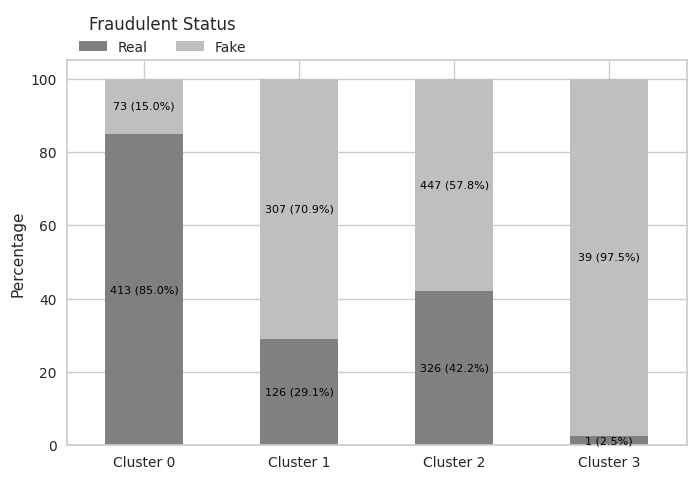

In [109]:
# Create a wide-format table for plotting
pct_table = tbl_pct.T
count_table = tbl.T

# Plot a stacked bar chart
# colors = ['#000000', '#404040', '#808080', '#BFBFBF', '#F0F0F0']
colors = ['#808080', '#BFBFBF']
ax = pct_table.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors)

# Annotate each bar with the count and percentage
for i, bar in enumerate(ax.patches):
    # Find the center of each bar segment
    h = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2

    # Find the count data corresponding to the current bar
    row = i % 4    # Integer division to find the row in the count table
    col = i // 4   # Remainder to find the column in the count table
    count = count_table.iloc[row, col]

    # The percentage is the height of the bar
    percentage = h
    
    # Only add text annotations if the bar segment has a visible height
    if h > 0:
        ax.text(x, bar.get_y() + h / 2, f'{int(count)} ({percentage:.1f}%)', 
                ha='center', va='center', color='black', fontsize=8)

# Rotate x-tick labels to be horizontal
plt.xticks(rotation=0)
plt.ylabel('Percentage')
# plt.title('Percentage of Fraudulent Posts by Cluster')

plt.legend(title='Fraudulent Status', labels=['Real', 'Fake'], loc='upper left', bbox_to_anchor=(0, 1.15), ncol=2)
# plt.legend(title='Fraudulent Status', labels=['Real', 'Fake'], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
# plt.legend(title='Fraudulent Status', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.show()

Given the chi-square statistic and the extremely small p-value, we reject the null hypothesis, indicating a statistically significant association between the cluster assignments and the 'fraudulent' status of job postings. To understand the strength of this relationship between the two nominal variables, we need to calculate Cramer's V.



### Cramer's V

- Cramer's V measures how strongly two nominal variables are associated.
- It ranges from 0 to 1, where 0 means no association and 1 is full association.
- The higher the value, the stronger the association.

$$ V = \sqrt{\frac{\chi^2 / n}{\min(k - 1, r - 1)}} $$
where:   
- $\chi^2$ is the chi-square statistic from the contingency table.   
- $n$ is the total sample size.   
- $k$ and $r$ are the number of columns and rows in the contingency table, respectively.   
- $\min(k - 1, r - 1)$ ensures normalization for tables of different sizes

In [12]:
n = tbl.sum().sum()  # Total sample size
k = min(tbl.shape)   # The lesser number of categories between rows and columns

# Calculating Cramer's V
cramers_v = np.sqrt(chi2 / (n * (k-1)))

print(f"Cramer's V = {cramers_v:.4f}")

Cramer's V = 0.4613


The Cramer's V value of 0.4613 suggests a moderate to strong association. It is not enough to say there is a remarkably strong link between the clusters and the 'fraudulent' label, but there is a more significant relationship than chance would explain.

In conclusion, clustering analysis appears to be effective in distinguishing fraudulent job postings from non-fraudulent ones, which could be beneficial for developing a predictive model.

# Classification

In [114]:
print(doc_vectors.shape)
df_nlp['fraudulent'].head()

(1732, 300)


0    0
1    1
2    1
3    0
4    1
Name: fraudulent, dtype: int64

## Logistic Regression

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def logistic_regression(doc_vectors, labels, test_size=0.2, random_state=99):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(doc_vectors, labels, test_size=test_size, random_state=random_state)
    print("Train set shape:", X_train.shape, y_train.shape)
    print("Test set shape :", X_test.shape, y_test.shape)
    print("#"*50)
    
    # Initialize the logistic regression model
    log_reg = LogisticRegression(solver='liblinear')  # 'liblinear' solver is a good choice for small datasets

    # Train the model
    log_reg.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = log_reg.predict(X_test)

    # Print the accuracy and a classification report to evaluate performance
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Visualize the confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)

    # Adding labels for axes and title for clarity
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')

    # Adding ticks
    plt.xticks([0.5, 1.5], ['Non-Fraudulent', 'Fraudulent'])
    plt.yticks([0.5, 1.5], ['Non-Fraudulent', 'Fraudulent'], va='center')

    # Display the confusion matrix
    plt.show()

    return acc

In [116]:
doc_vectors.shape

(1732, 300)

In [118]:
df_nlp[['telecommuting', 'has_no_company_logo', 'has_no_questions']]

,telecommuting,has_no_company_logo,has_no_questions
0,0,0,0
1,0,1,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1727,0,1,0
1728,0,1,1
1729,0,1,1
1730,0,0,0


## Cluster Assignment as Feature

- Features: Cluster assignments
- Target: fraudulent or not

In [125]:
from sklearn.preprocessing import OneHotEncoder

cluster_assignment = df_nlp['cluster_4'].to_numpy().reshape(-1, 1)  # Reshape it to be a 2D array

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False means the output will be a dense array

# Fit and transform the cluster_assignment
cluster_one_hot = encoder.fit_transform(cluster_assignment)

In [126]:
cluster_one_hot

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [57]:
import statsmodels.api as sm

X = cluster_one_hot
y = df_nlp['fraudulent'].to_numpy()

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.576037
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1732
Model:                          Logit   Df Residuals:                     1728
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1690
Time:                        14:51:21   Log-Likelihood:                -997.70
converged:                       True   LL-Null:                       -1200.5
Covariance Type:            nonrobust   LLR p-value:                 1.308e-87
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.7330      0.127    -13.649      0.000      -1.982      -1.484
x2             0.8906      0.

Train set shape: (1385, 4) (1385,)
Test set shape : (347, 4) (347,)
##################################################
Accuracy: 0.69

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.47      0.60       174
           1       0.63      0.91      0.75       173

    accuracy                           0.69       347
   macro avg       0.74      0.69      0.67       347
weighted avg       0.74      0.69      0.67       347



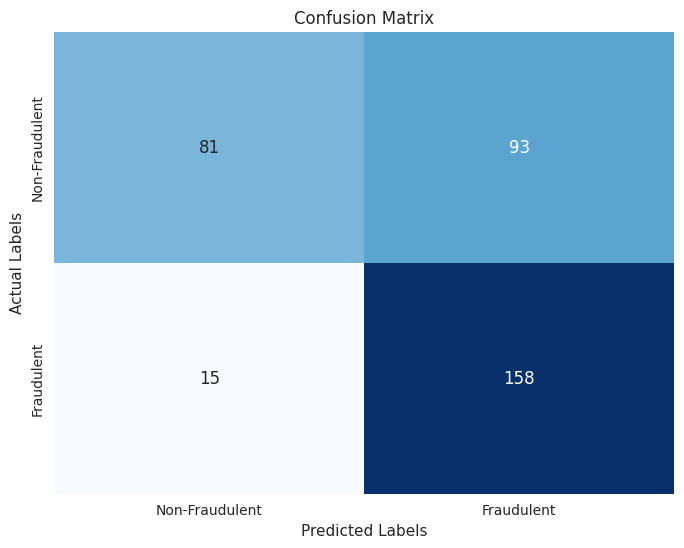

In [ ]:
X = cluster_one_hot
y = df_nlp['fraudulent']

acc0 = logistic_regression(X, y)

## Bootstrap resampling

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def bootstrap_metrics(X, y, n_bootstrap=300):
    indices = np.arange(y.shape[0])
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    for _ in range(n_bootstrap):
        # Bootstrap resampling
        boot_indices = resample(indices)
        X_train, X_test, y_train, y_test = train_test_split(X[boot_indices], y[boot_indices], test_size=0.2, random_state=99)
        
        # Create and train the model
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)
        
        # Predict on the out-of-bag sample
        y_pred = model.predict(X_test)
        
        # Calculate metrics and append to the respective lists
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1_score'].append(f1_score(y_test, y_pred, zero_division=0))

    return metrics

# Create a function to convert metrics data into a flattened list with model labels
def prepare_data_for_df(metrics, model_label):
    return {
        'model': [model_label] * len(metrics['accuracy']),
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score']
    }

X1 = cluster_one_hot
X2 = df_nlp[['telecommuting', 'has_no_company_logo', 'has_no_questions']].values
X3 = doc_vectors
X4 = np.hstack([cluster_one_hot, X2])
X5 = np.hstack([doc_vectors, X2])
X6 = np.hstack([doc_vectors, cluster_one_hot])
y = df_nlp['fraudulent'].to_numpy()

# Bootstrap resampling for each model
metrics_X1 = bootstrap_metrics(X1, y, n_bootstrap=1000)
metrics_X2 = bootstrap_metrics(X2, y, n_bootstrap=1000)
metrics_X3 = bootstrap_metrics(X3, y, n_bootstrap=1000)
metrics_X4 = bootstrap_metrics(X4, y, n_bootstrap=1000)
metrics_X5 = bootstrap_metrics(X5, y, n_bootstrap=1000)
metrics_X6 = bootstrap_metrics(X6, y, n_bootstrap=1000)

In [197]:
df_M1 = pd.DataFrame(metrics_X1)
df_M1['model'] = 'M1'
df_M2 = pd.DataFrame(metrics_X2)
df_M2['model'] = 'M2'
df_M3 = pd.DataFrame(metrics_X3)
df_M3['model'] = 'M3'
df_M4 = pd.DataFrame(metrics_X4)
df_M4['model'] = 'M4'
df_M5 = pd.DataFrame(metrics_X5)
df_M5['model'] = 'M5'
df_M6 = pd.DataFrame(metrics_X6)
df_M6['model'] = 'M6'

df_res = pd.concat([
    df_M1,
    df_M2,
    df_M3,
    df_M4,
    df_M5,
    df_M6,
], axis=0)

print("Shape:", df_res.shape)
print("#"*50)

df_res.head(3)

Shape: (6000, 5)
##################################################


,accuracy,precision,recall,f1_score,model
0,0.677233,0.619608,0.913295,0.738318,M1
1,0.677233,0.620155,0.919540,0.740741,M1
2,0.714697,0.660079,0.927778,0.771363,M1


## Statistical Analysis

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    M1     M2   0.0424    0.0  0.0398   0.045   True
    M1     M3   0.2082    0.0  0.2056  0.2108   True
    M1     M4   0.0484    0.0  0.0458  0.0511   True
    M1     M5   0.2199    0.0  0.2172  0.2225   True
    M1     M6   0.2092    0.0  0.2065  0.2118   True
    M2     M3   0.1658    0.0  0.1632  0.1685   True
    M2     M4    0.006    0.0  0.0034  0.0087   True
    M2     M5   0.1775    0.0  0.1749  0.1801   True
    M2     M6   0.1668    0.0  0.1642  0.1694   True
    M3     M4  -0.1598    0.0 -0.1624 -0.1572   True
    M3     M5   0.0116    0.0   0.009  0.0143   True
    M3     M6   0.0009 0.9105 -0.0017  0.0036  False
    M4     M5   0.1714    0.0  0.1688  0.1741   True
    M4     M6   0.1607    0.0  0.1581  0.1634   True
    M5     M6  -0.0107    0.0 -0.0133 -0.0081   True
----------------------------------------------

<Figure size 1000x600 with 0 Axes>

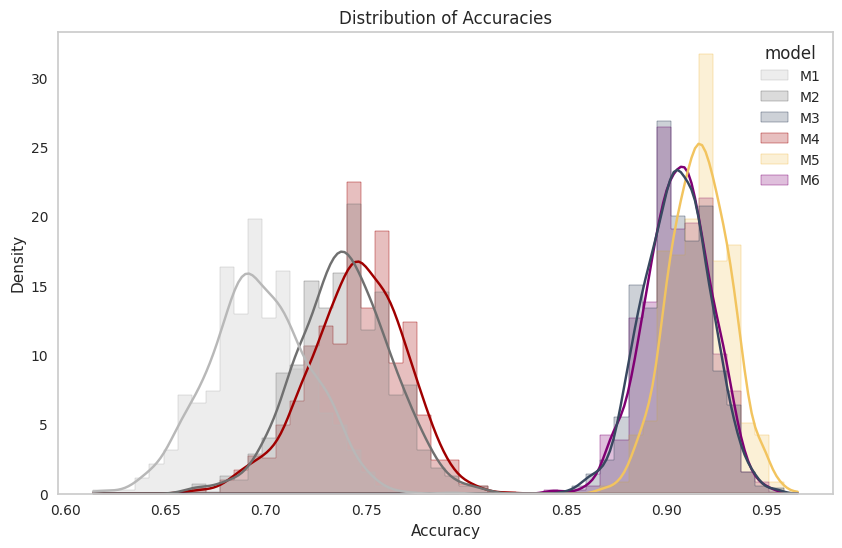

In [212]:
# Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_res['accuracy'],
                          groups=df_res['model'],
                          alpha=0.05)

# Display the test results
print(tukey)

# Visualization
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Optionally set the figure size
sns.histplot(data=df_res, x="accuracy", bins=50, hue="model", palette=colors, 
             kde=True, element="step", stat="density", common_norm=False, legend=True)

# Customize the plot aesthetics
plt.grid(False)  # Remove grid
plt.title('Distribution of Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Density')


plt.show()

In [178]:
# Group the data by model and calculate mean and standard deviation
acc_stats = df_res.groupby('model')['accuracy'].agg(['mean', 'std'])
acc_stats['mean'] = acc_stats['mean'].apply(lambda x: f"{x * 100:.1f} %")
acc_stats['std'] = acc_stats['std'].apply(lambda x: f"{x * 100:.1f} %")
acc_stats

,mean,std
model,,
X1,69.6 %,2.5 %
X2,73.9 %,2.4 %
X3,90.6 %,1.6 %
X4,74.4 %,2.5 %
X5,91.5 %,1.5 %
X6,90.6 %,1.6 %


In [179]:
import pingouin as pg # Statistics library

hsd = pg.pairwise_tukey( # Using pingouin for stats
    data=df_res, #! A dataframe
    dv="accuracy", #! The name of the column with the dependent variable
    between="model", #! The name of the column with group labels
    effsize="cohen" # Cohen's d for effect size
    ).round(3) # rounding can greatly improve readability
display(hsd)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,X1,X2,0.696,0.739,-0.042,0.001,-45.748,0.00,-1.742
1,X1,X3,0.696,0.906,-0.209,0.001,-226.521,0.00,-9.959
2,X1,X4,0.696,0.744,-0.048,0.001,-52.000,0.00,-1.936
3,X1,X5,0.696,0.915,-0.219,0.001,-236.880,0.00,-10.677
4,X1,X6,0.696,0.906,-0.210,0.001,-227.139,0.00,-10.051
5,X2,X3,0.739,0.906,-0.167,0.001,-180.773,0.00,-8.155
6,X2,X4,0.739,0.744,-0.006,0.001,-6.252,0.00,-0.237
7,X2,X5,0.739,0.915,-0.176,0.001,-191.132,0.00,-8.852
8,X2,X6,0.739,0.906,-0.167,0.001,-181.391,0.00,-8.239
9,X3,X4,0.906,0.744,0.161,0.001,174.521,0.00,7.631


# Evaluation

/tmp/ipykernel_1306086/2603468302.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x="model", y="accuracy", palette=colors, inner=None, fill=False)  # No quartiles inside the violin


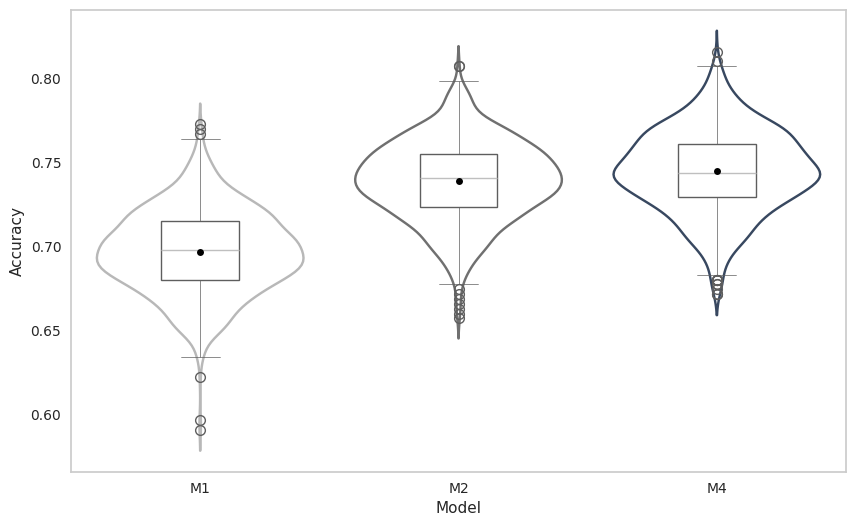

In [180]:
# Create a DataFrame from the data dictionary
df_data = pd.DataFrame(data)
df_plot = df_data[df_data['model'].isin(["X1", "X2", "X4"])]

# Set the color palette
colors = ['#b8b8b8', '#707070', '#384860']  # Assuming you have defined these colors

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_plot, x="model", y="accuracy", palette=colors, inner=None, fill=False)  # No quartiles inside the violin

# Overlay with a box plot
sns.boxplot(data=df_plot, x="model", y="accuracy", width=0.3, showmeans=True,
             boxprops={'facecolor': 'None'},  # Makes the box transparent
             whiskerprops={'linewidth': 0.5}, 
             capprops={'linewidth': 0.5},
             medianprops={'color': '#BFBFBF'},  # Set median line color
             meanprops={"marker": "o", "markerfacecolor": "#000000", "markeredgecolor": "black", "markersize": "5"})  # Customize mean point

# Customize x-tick labels
plt.xticks([0, 1, 2], ["M1", "M2", "M4"])

# Add titles and labels
plt.grid(False)  # Remove grid
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

/tmp/ipykernel_1306086/3308698877.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x="model", y="accuracy", palette=colors, inner=None, fill=False)  # No quartiles inside the violin


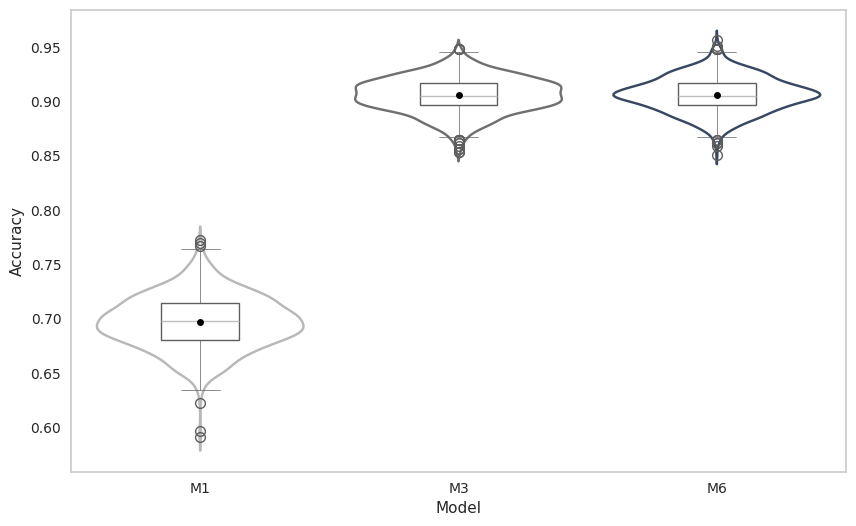

In [181]:
# Create a DataFrame from the data dictionary
df_data = pd.DataFrame(data)
df_plot = df_data[df_data['model'].isin(["X1", "X3", "X6"])]

# Set the color palette
colors = ['#b8b8b8', '#707070', '#384860']  # Assuming you have defined these colors

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_plot, x="model", y="accuracy", palette=colors, inner=None, fill=False)  # No quartiles inside the violin

# Overlay with a box plot
sns.boxplot(data=df_plot, x="model", y="accuracy", width=0.3, showmeans=True,
             boxprops={'facecolor': 'None'},  # Makes the box transparent
             whiskerprops={'linewidth': 0.5}, 
             capprops={'linewidth': 0.5},
             medianprops={'color': '#BFBFBF'},  # Set median line color
             meanprops={"marker": "o", "markerfacecolor": "#000000", "markeredgecolor": "black", "markersize": "5"})  # Customize mean point

# Customize x-tick labels
plt.xticks([0, 1, 2], ["M1", "M3", "M6"])

# Add titles and labels
plt.grid(False)  # Remove grid
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()